In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma
import struct
import os
import xarray as xr
import glob
import datetime 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import pandas as pd

# ESIO Imports
import esio
import esiodata as ed

import dask
dask.set_options(get=dask.threaded.get)
# from dask.distributed import Client, progress
# client = Client(processes=12)

# General plotting settings
sns.set_style('ticks')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.rcParams.update({'figure.max_open_warning': 0})

#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()
data_dir = E.data_dir
grid_dir = E.grid_dir

In [2]:
runType = 'forecast'
variables = ['sic']
cvar = variables[0]

In [3]:
# Define models to plot
models_2_plot = list(E.model.keys())
models_2_plot = [x for x in models_2_plot if x!='piomas'] # remove some models

gfdlsipn
yopp
bom
cma
ecmwf
hcmr


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


isaccnr
jma
metreofr
ukmo
eccc
kma
ncep
ukmetofficesipn
ecmwfsipn


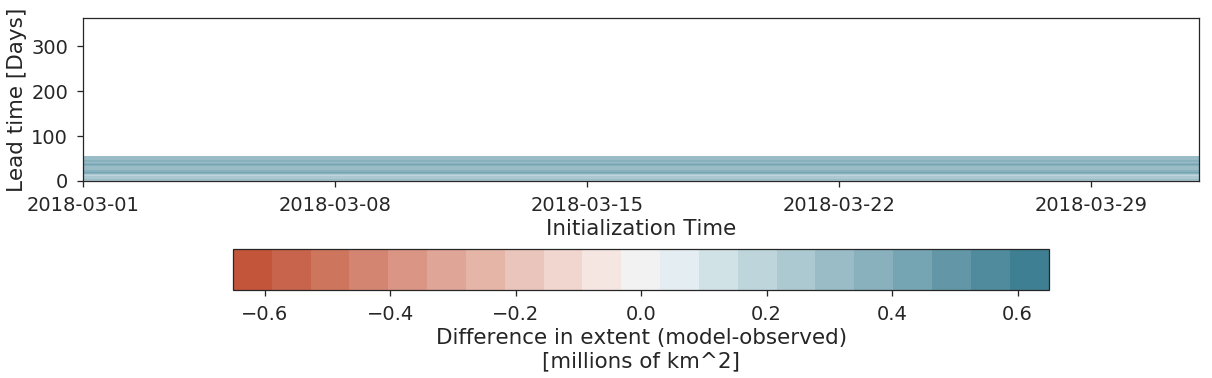

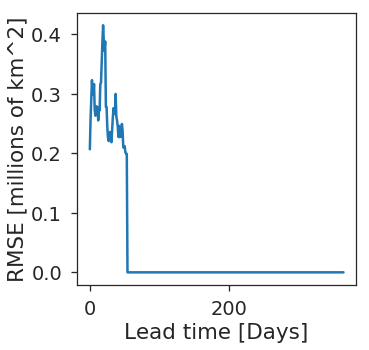

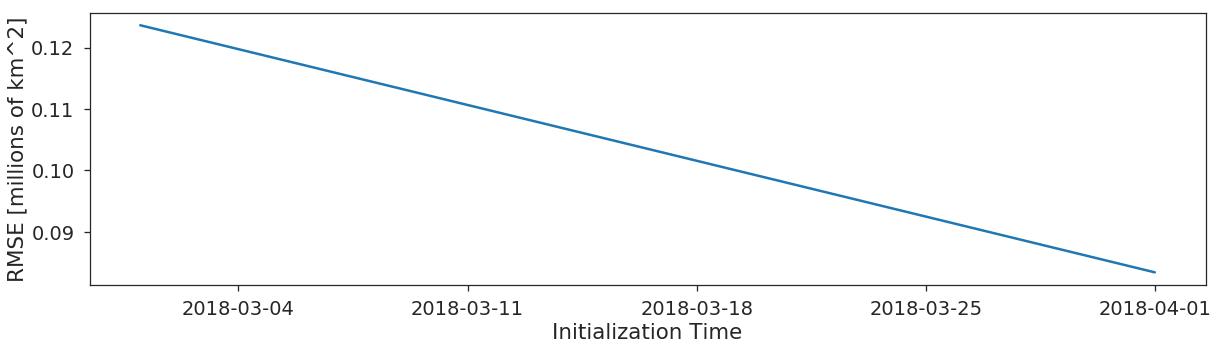

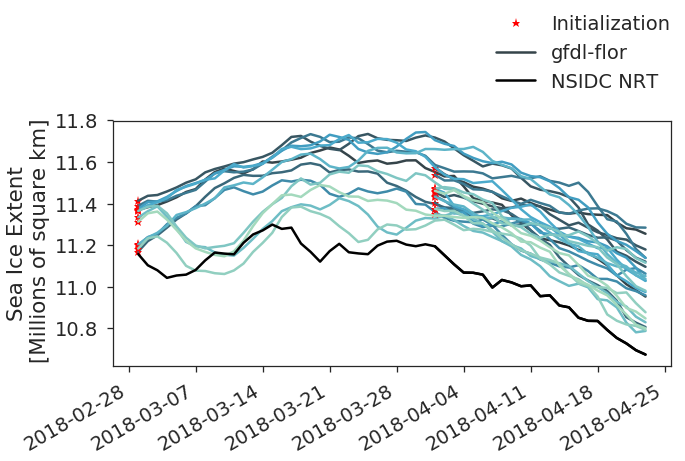

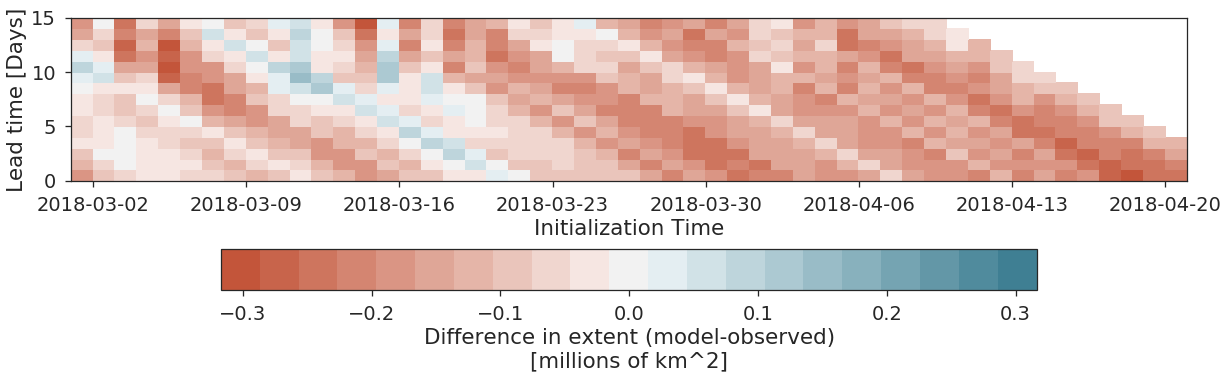

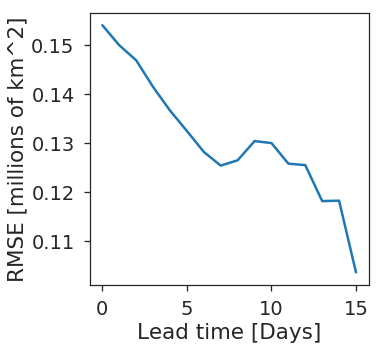

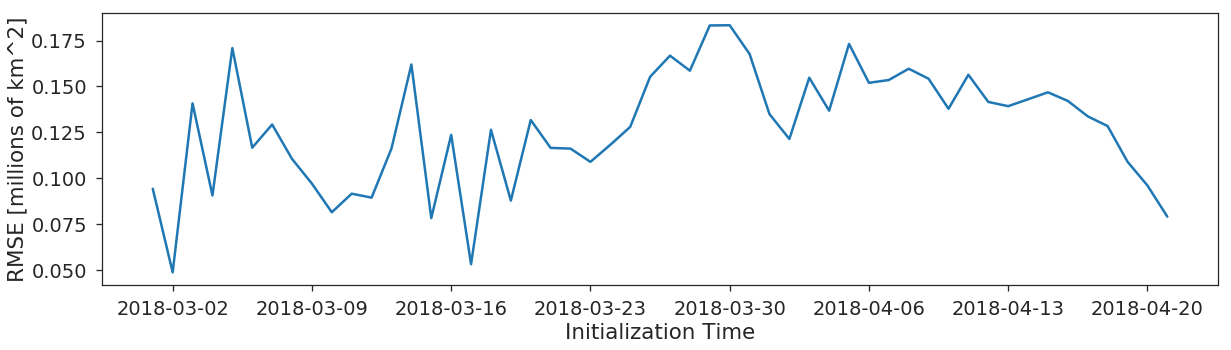

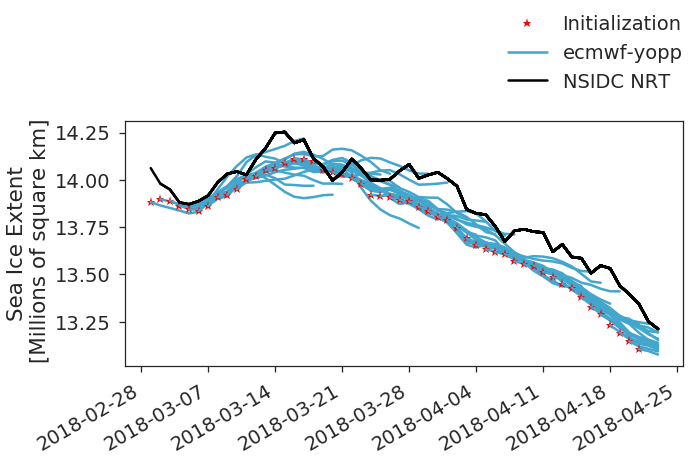

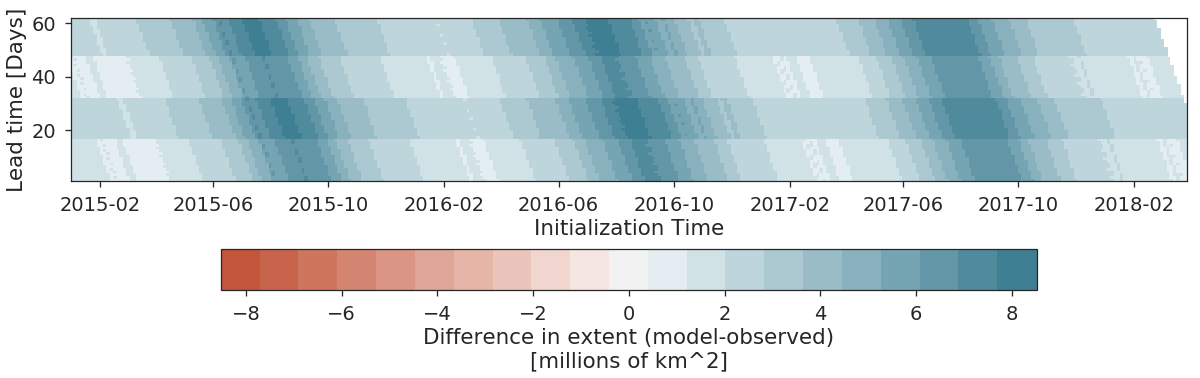

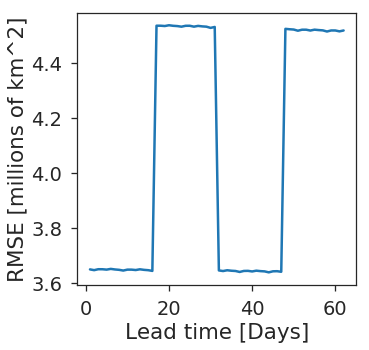

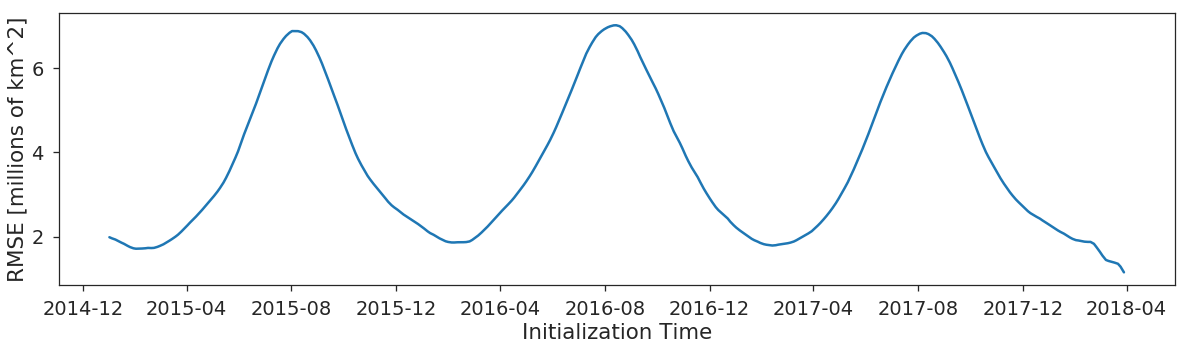

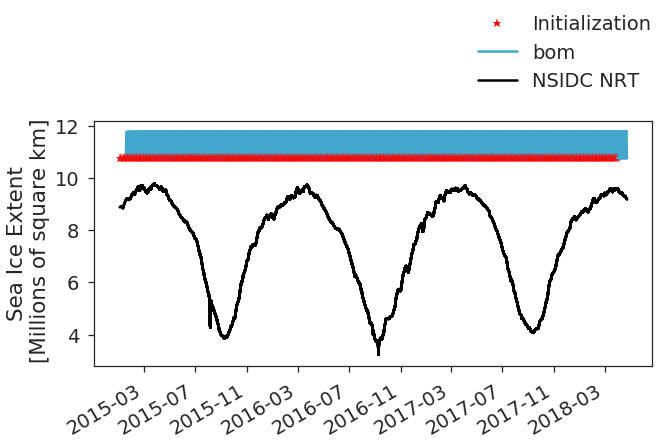

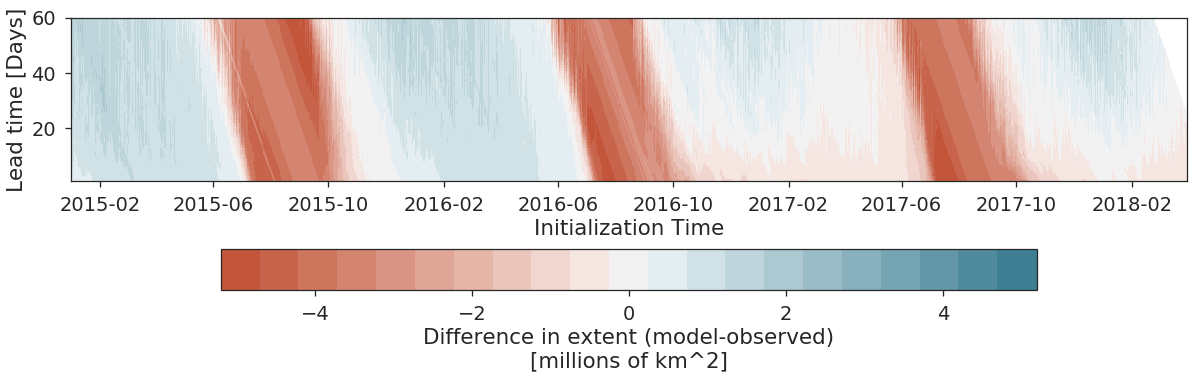

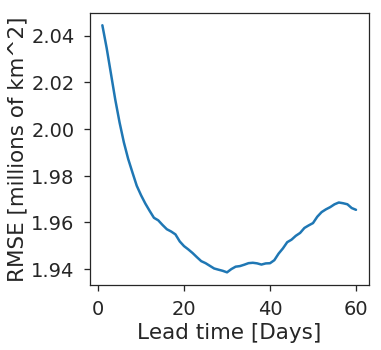

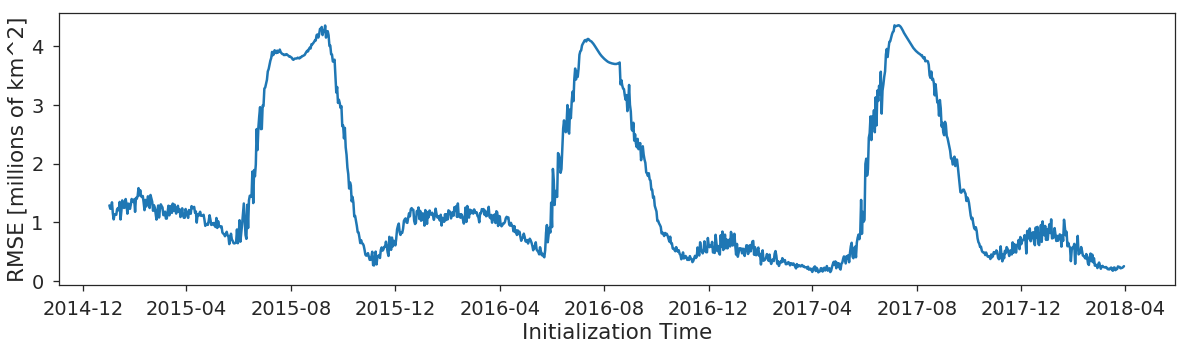

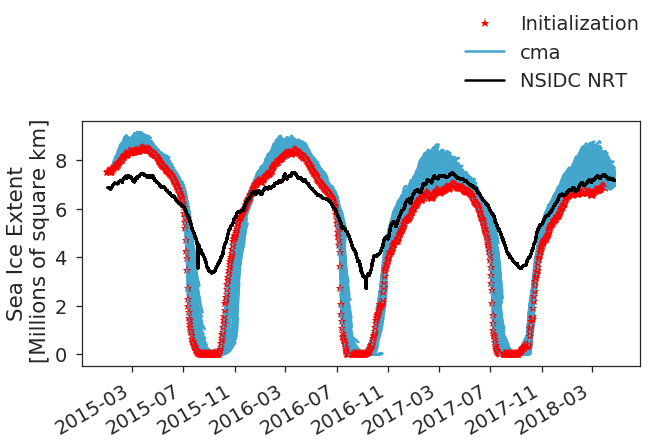

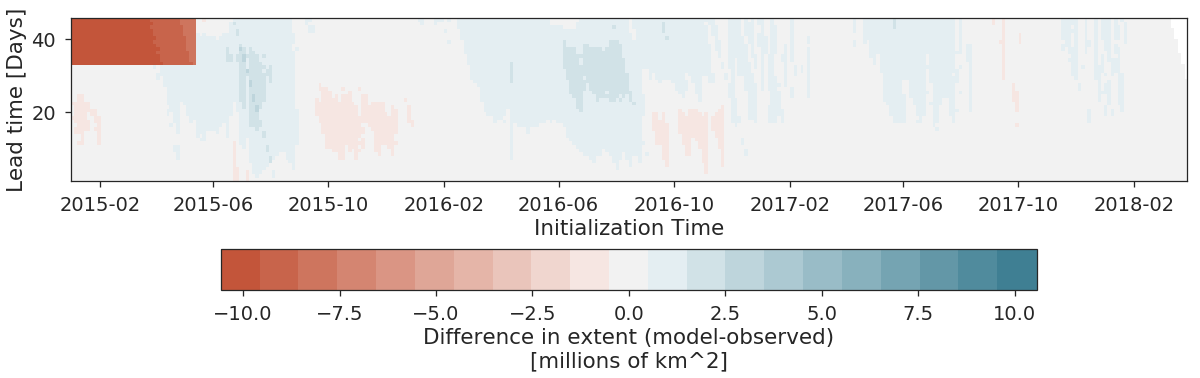

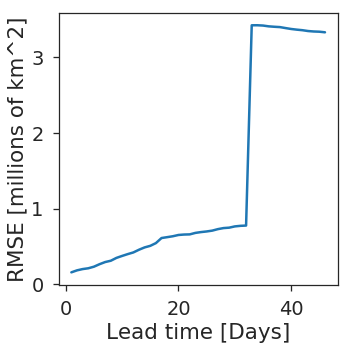

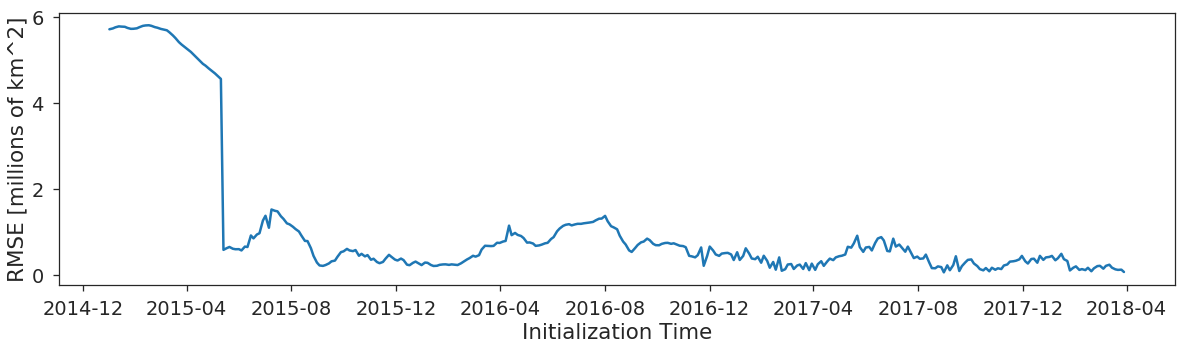

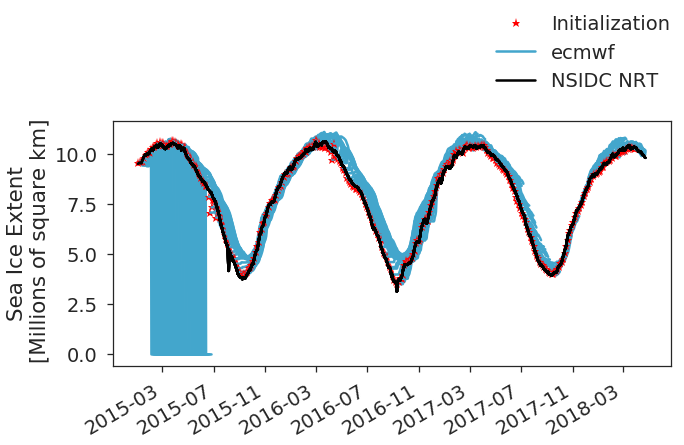

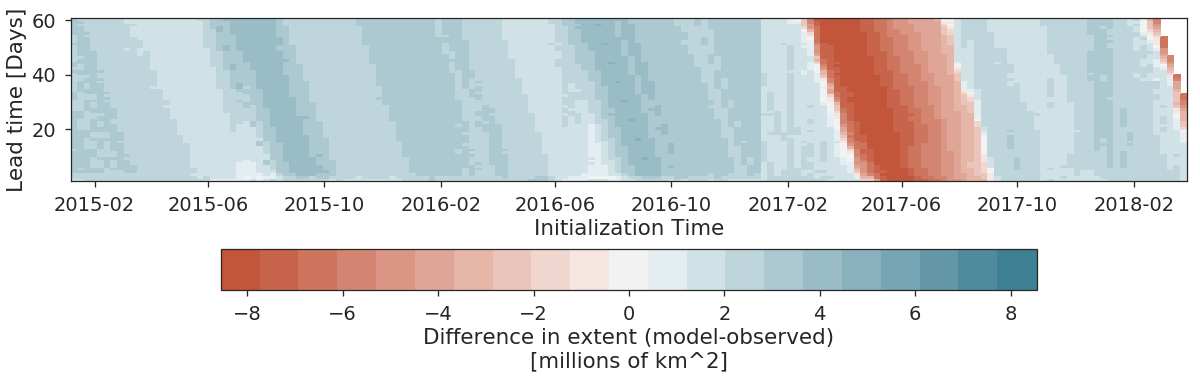

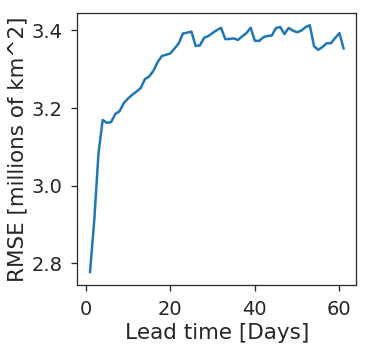

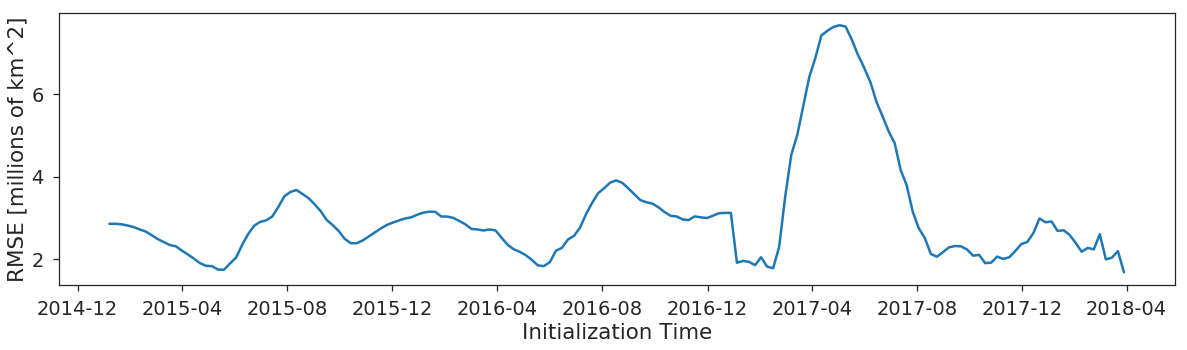

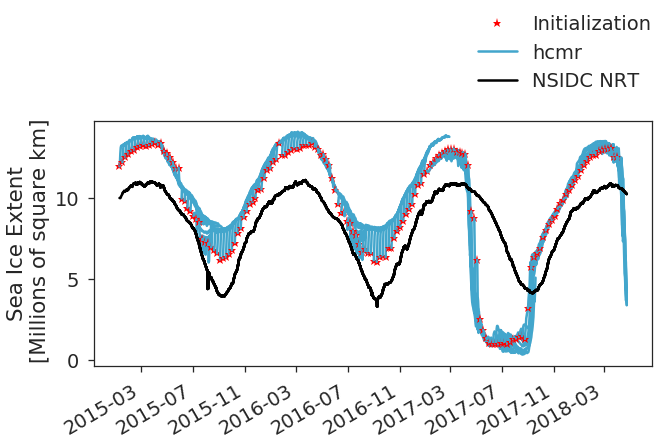

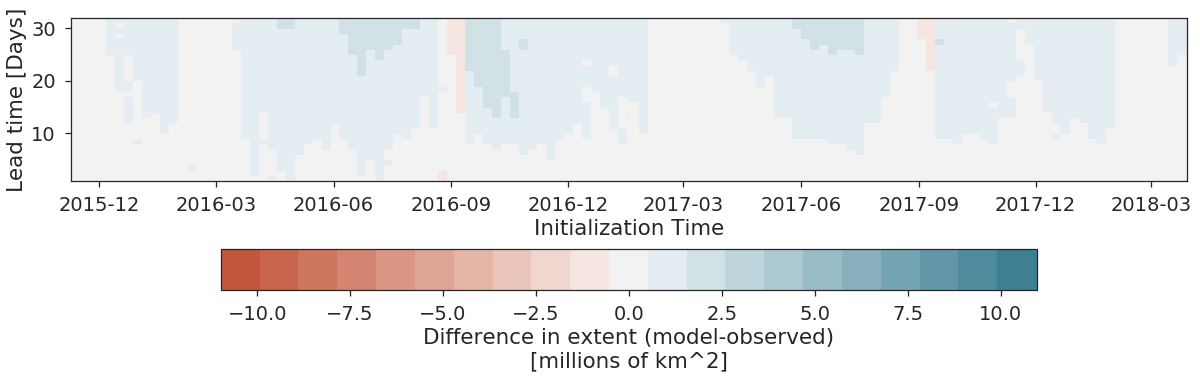

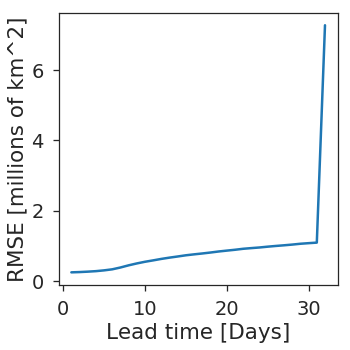

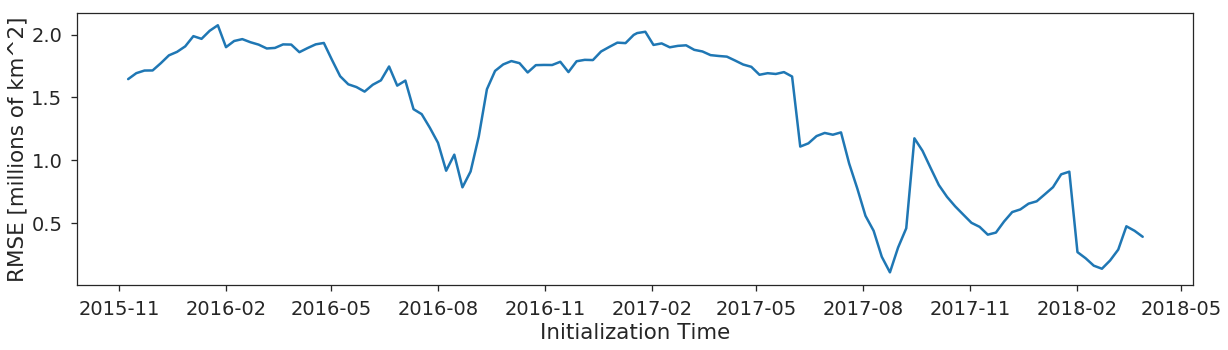

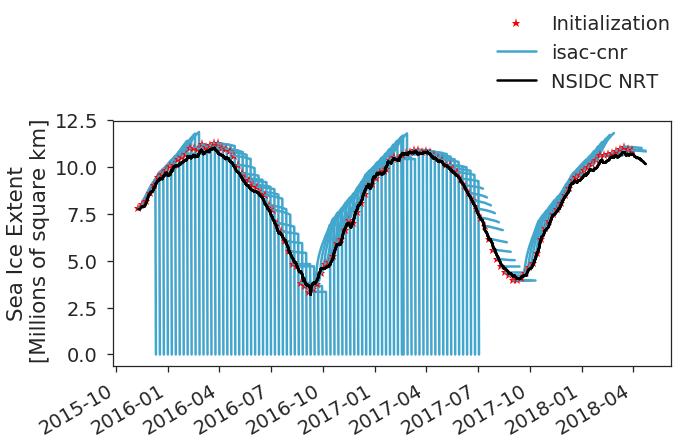

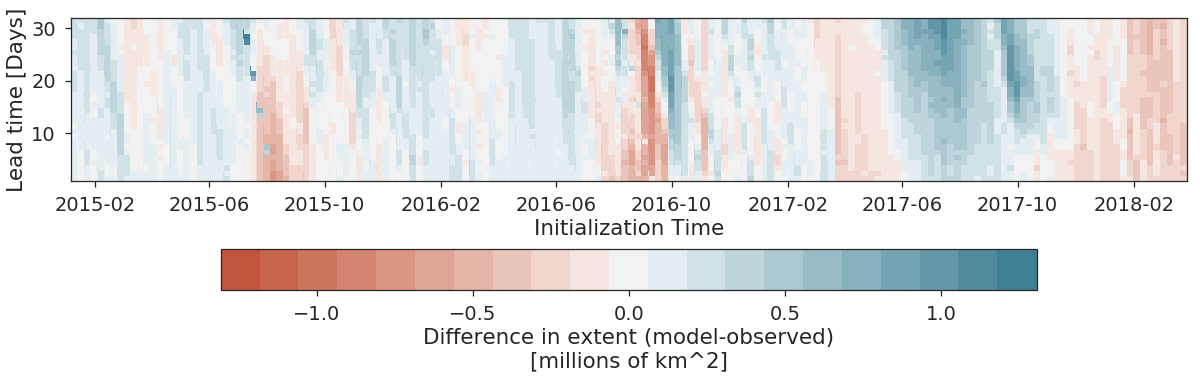

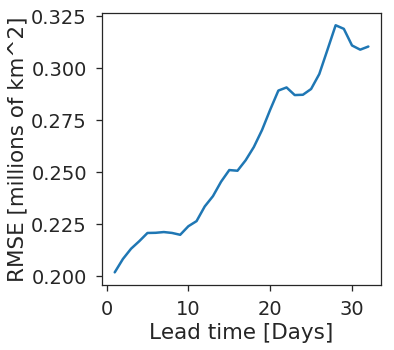

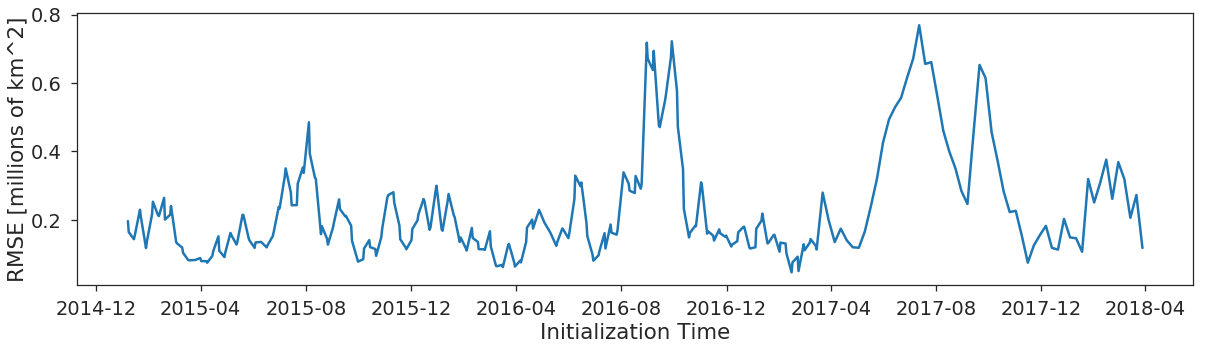

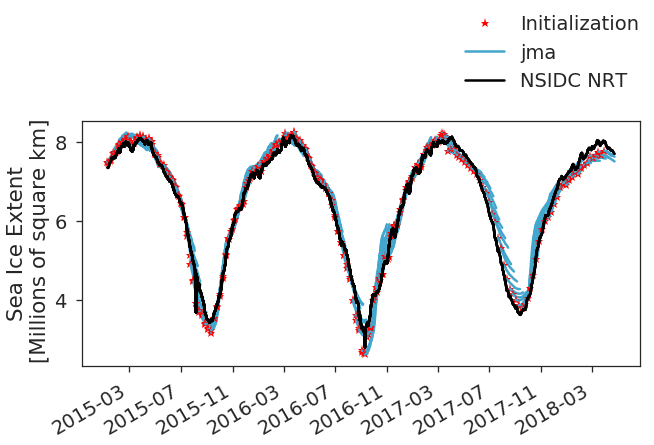

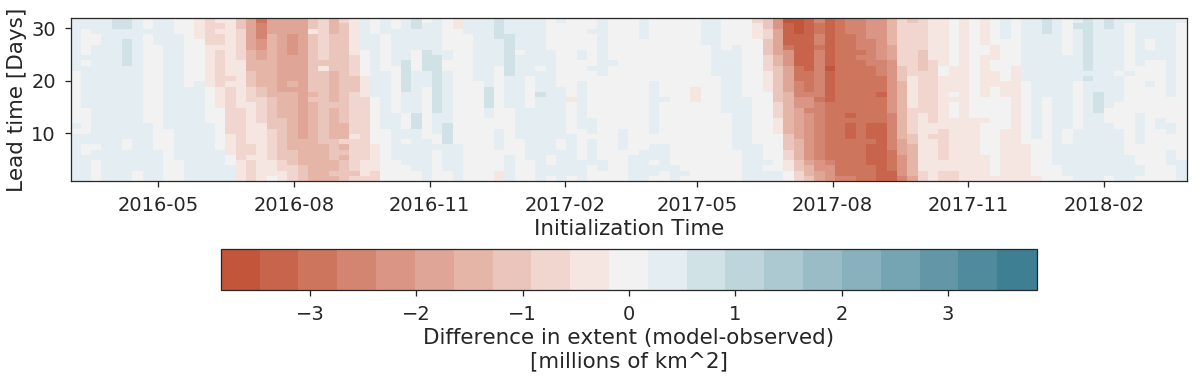

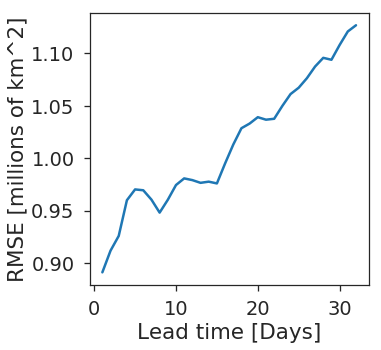

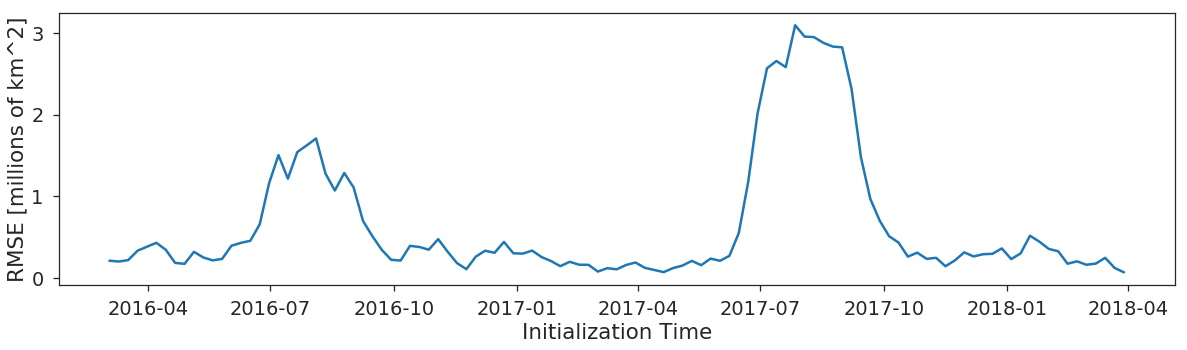

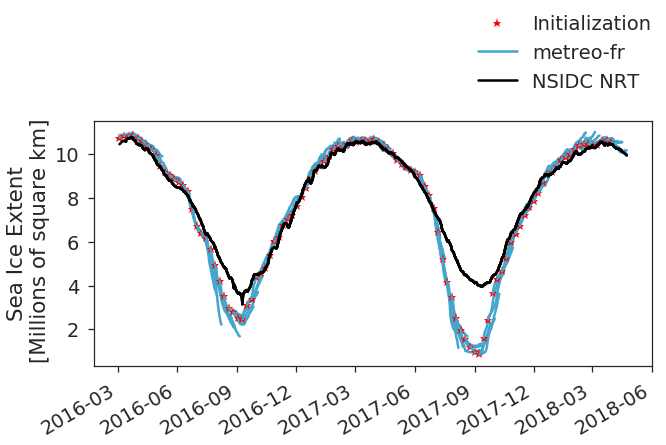

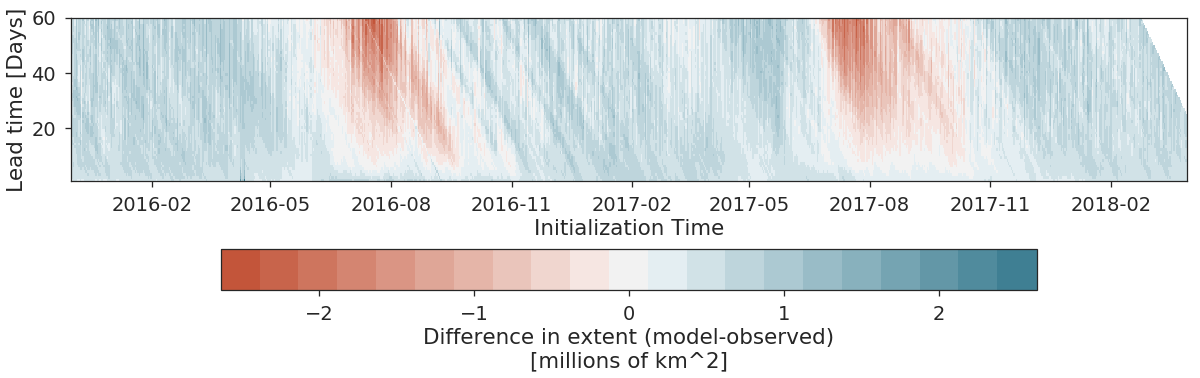

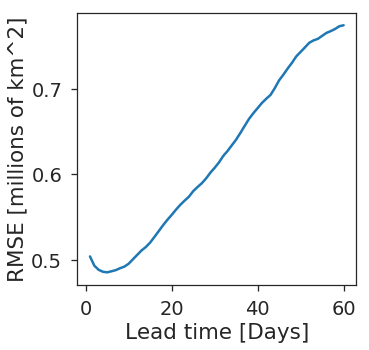

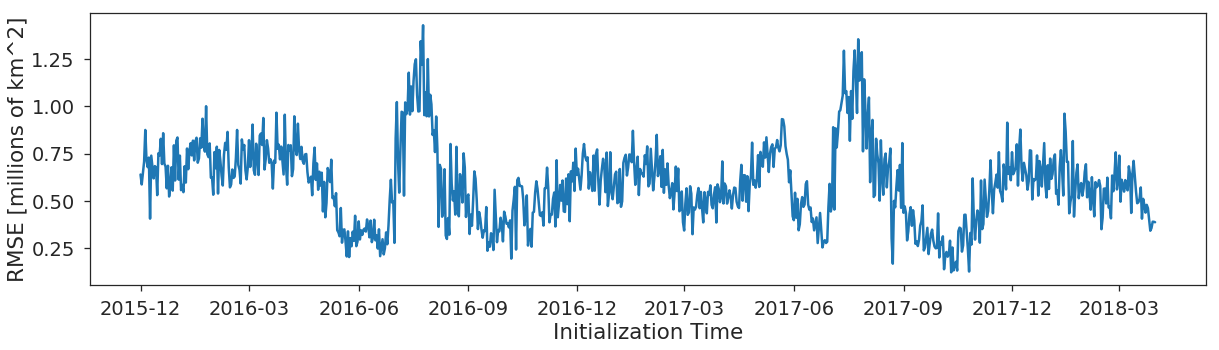

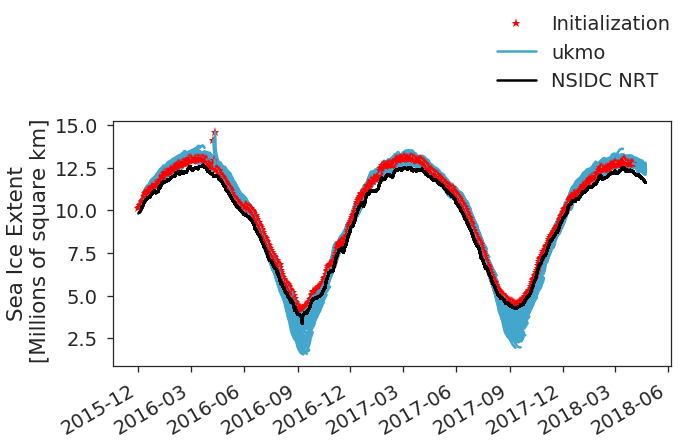

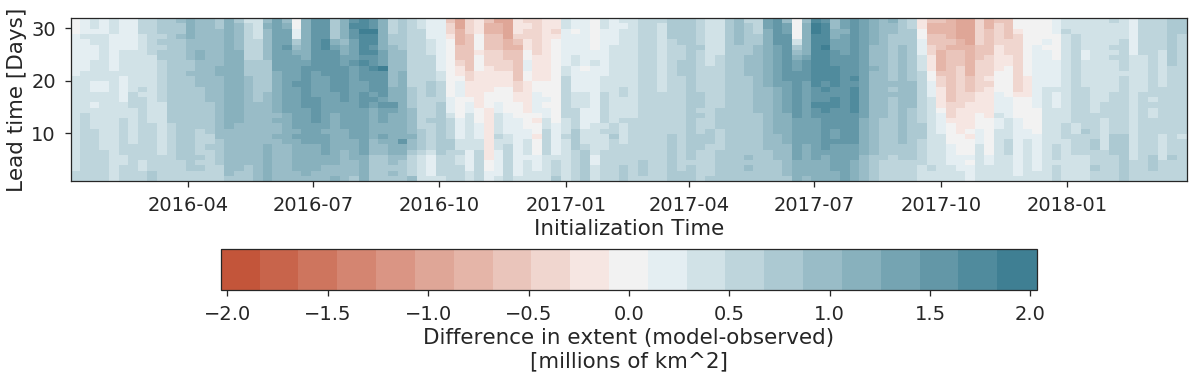

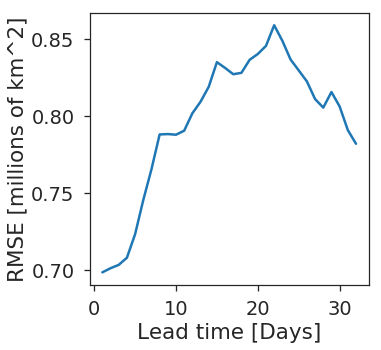

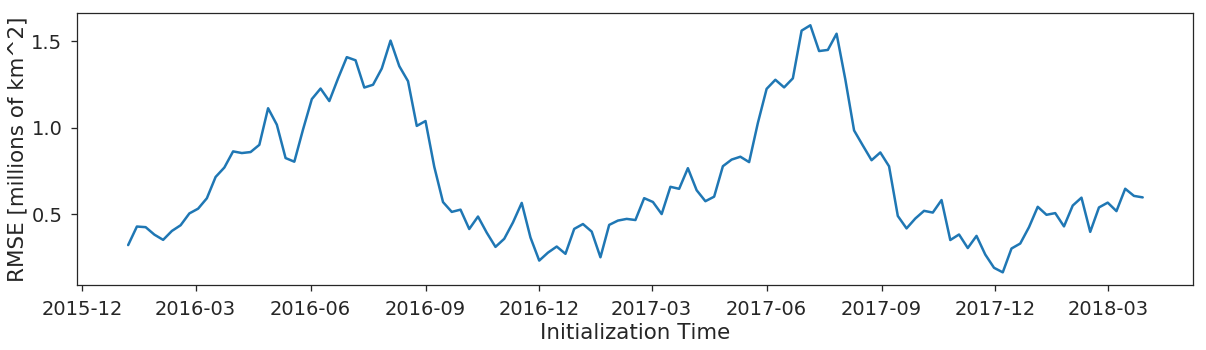

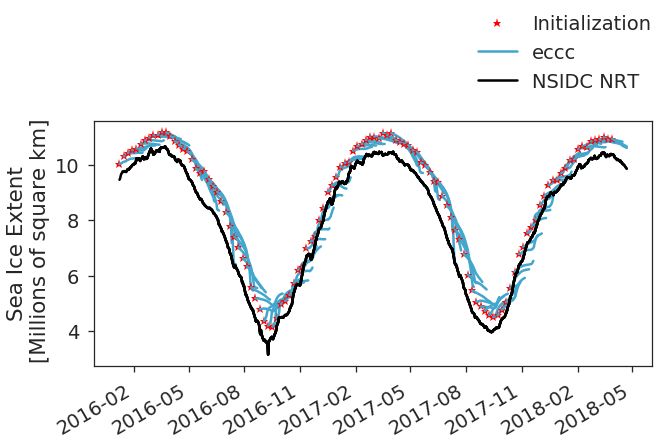

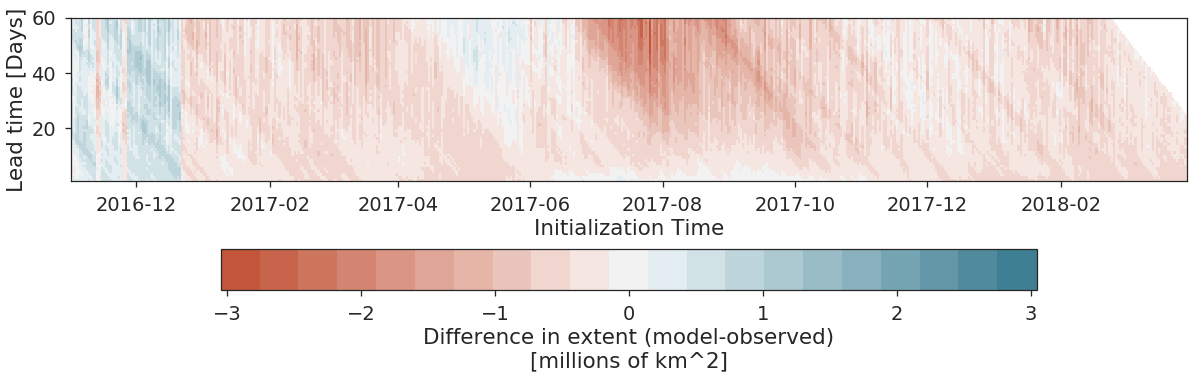

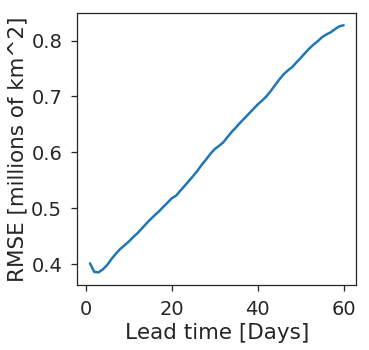

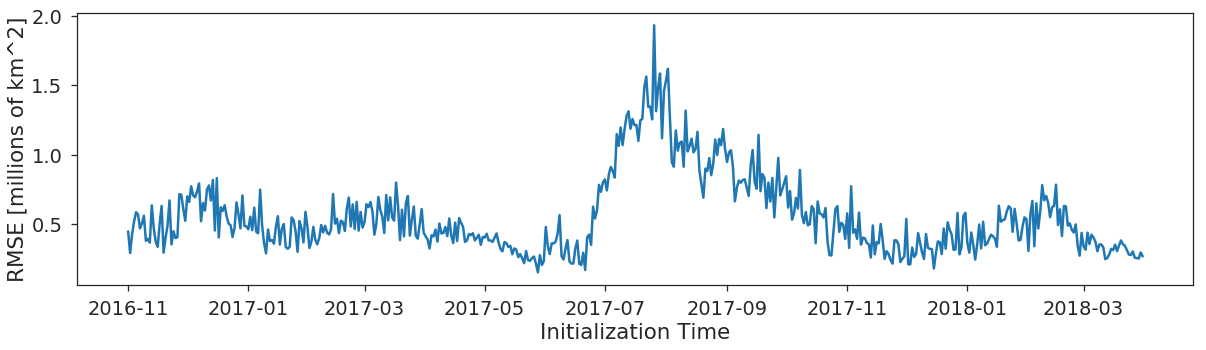

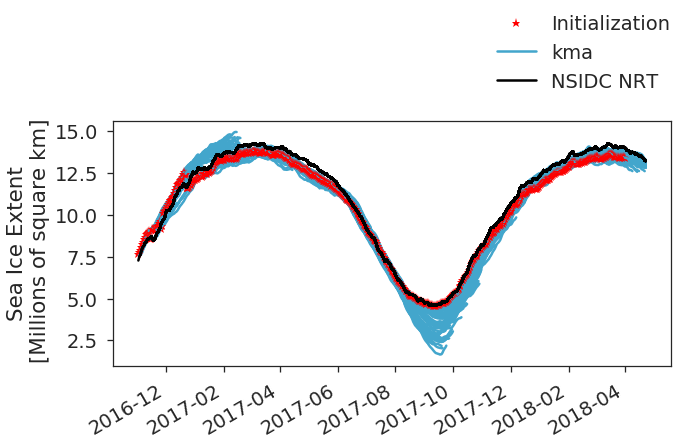

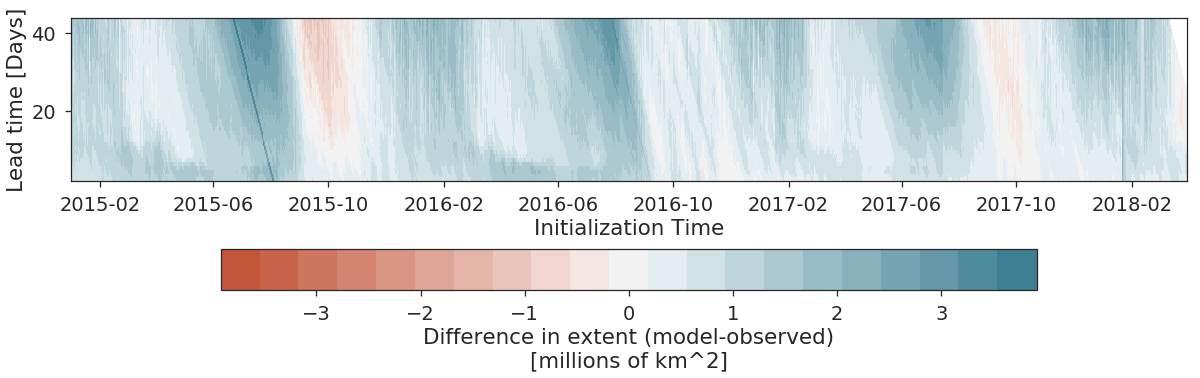

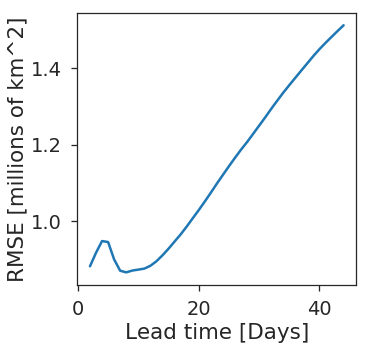

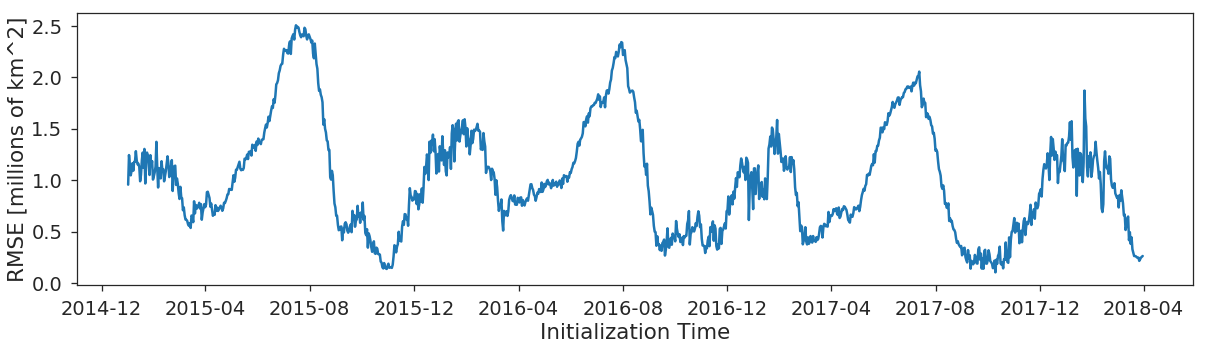

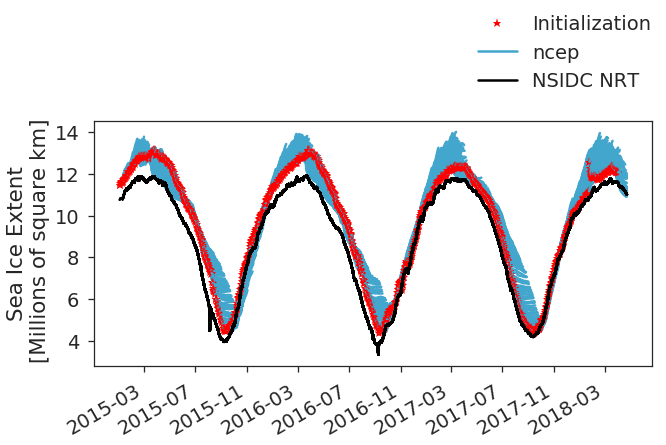

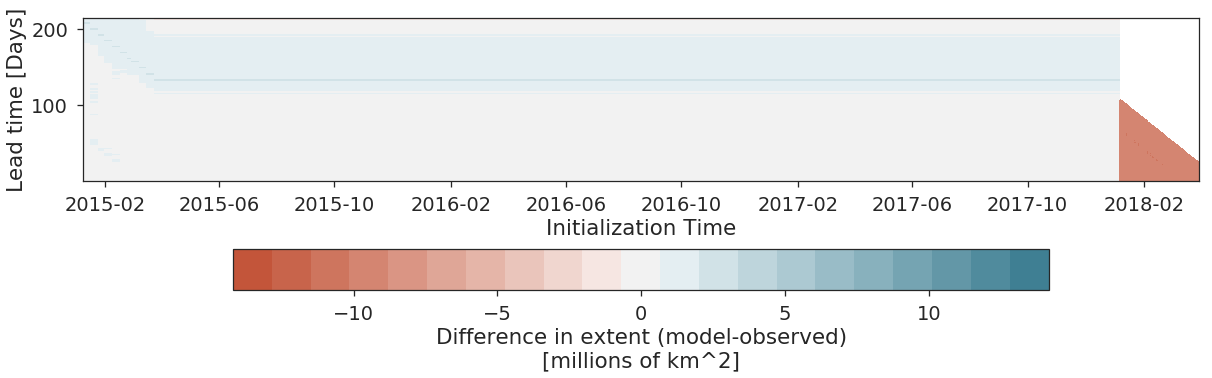

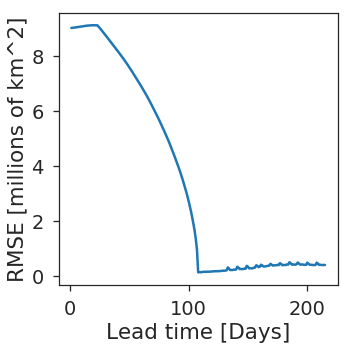

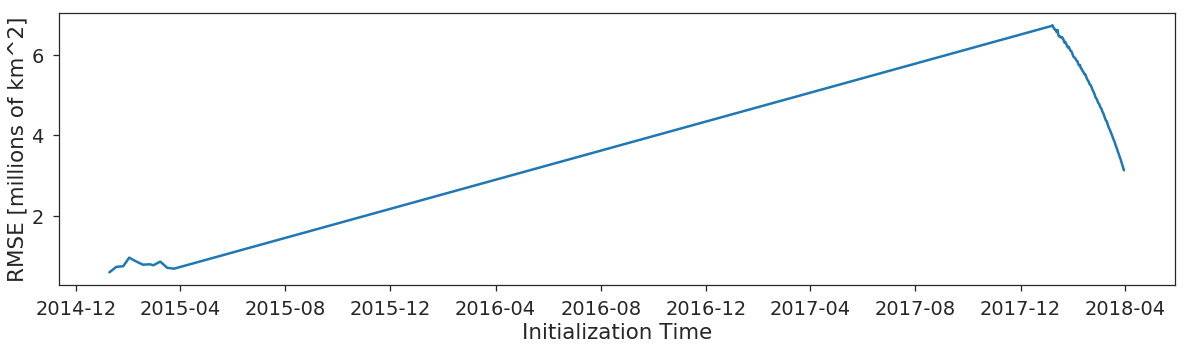

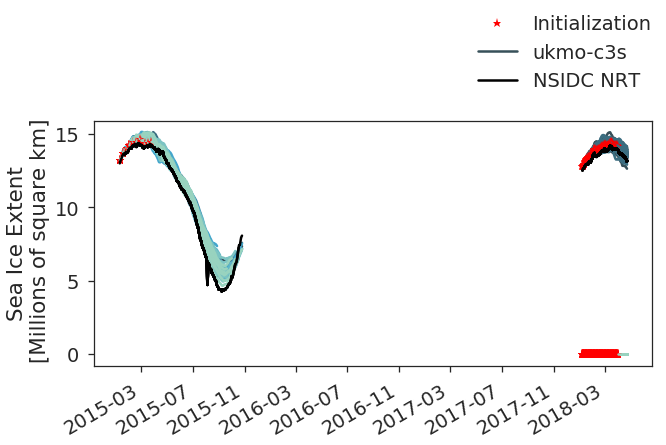

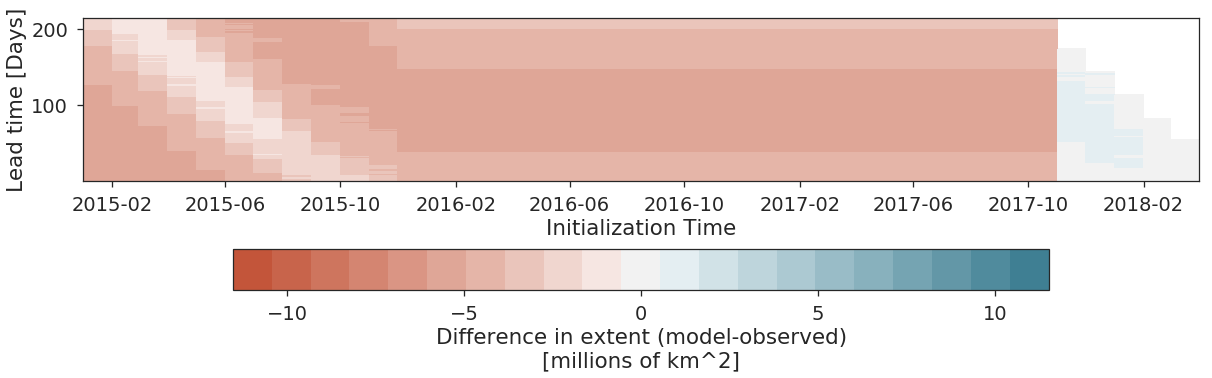

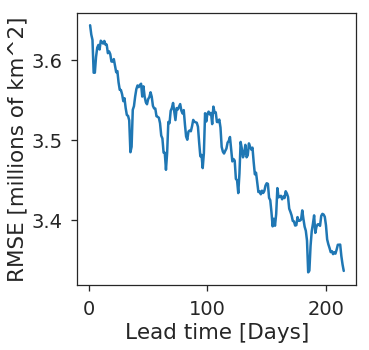

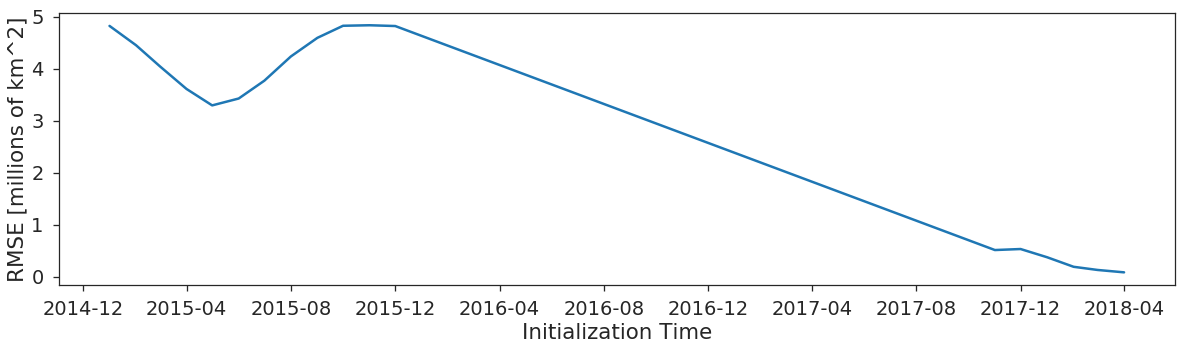

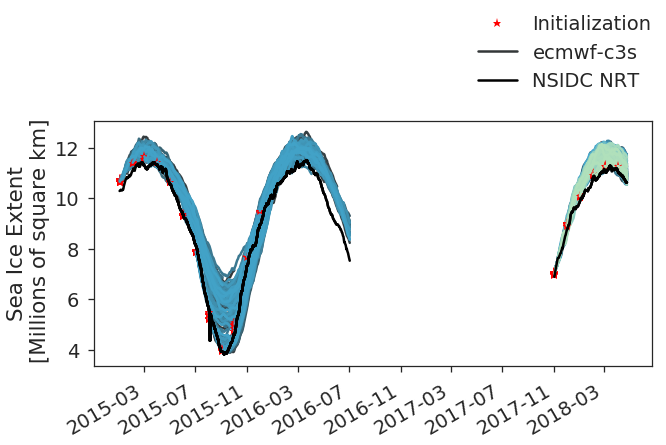

In [4]:
for (i, c_model) in enumerate(models_2_plot):
    print(c_model)
    
    # Load in data
    # Check file exists
    nc_file = os.path.join(data_dir, 'model', c_model , 'forecast', 'agg_nc', c_model+'_extent.nc')
    if os.path.isfile(nc_file):
        ds_mrg = xr.open_dataset(nc_file)
    else:
        print('No file found... skipping...')
        continue

    # Plotting color maps
    cmap_diff = matplotlib.colors.ListedColormap(sns.diverging_palette(20,  220, n=21))
    # Calculate differences for each ensemble (0...N) from obseerved (-1)
    MOdiff = (ds_mrg[cvar].sel(ensemble=slice(0,ds_mrg.ensemble.size)) - ds_mrg[cvar].sel(ensemble=-1) )
    abs_max = np.max([MOdiff.min()*-1, MOdiff.max()])
    MOdiff_avg = MOdiff.mean(dim='ensemble')

    plt.figure(figsize=(20,5))
    plt.pcolormesh(ds_mrg.init_time.values, ds_mrg.fore_time.values.astype('timedelta64[D]').astype('int'), 
                   MOdiff_avg.T.values,
                  cmap=cmap_diff, vmin=-1*abs_max, vmax=abs_max)
    plt.ylabel('Lead time [Days]')
    plt.xlabel('Initialization Time')
    cb = plt.colorbar(orientation='horizontal', label='Difference in extent (model-observed)\n[millions of km^2]', pad=0.25)

    
    
    
    rmse_fore_time = np.sqrt(((MOdiff_avg**2).sum(dim='init_time').values)/MOdiff_avg.init_time.size)
    plt.figure(figsize=(5,5))
    plt.plot(MOdiff.fore_time.values.astype('timedelta64[D]').astype('int'), rmse_fore_time)
    plt.ylabel('RMSE [millions of km^2]')
    plt.xlabel('Lead time [Days]')

    
    
    
    rmse_init_time = np.sqrt(((MOdiff_avg**2).sum(dim='fore_time').values)/MOdiff_avg.fore_time.size)
    plt.figure(figsize=(20,5))
    plt.plot(MOdiff.init_time.values, rmse_init_time)
    plt.ylabel('RMSE [millions of km^2]')
    plt.xlabel('Initialization Time')

    
    
    
    # Plot pan-Arctic sea ice extent
    f = plt.figure(figsize=(10,5))
    ax1 = plt.subplot(1, 1, 1) # Observations
    esio.plot_reforecast(ds=ds_mrg.sel(ensemble=slice(0,ds_mrg.ensemble.size)).sic, 
                         axin=ax1, labelin=E.model[c_model]['model_label'],
                         color='cycle_ensemble', marker=None)
    esio.plot_reforecast(ds=ds_mrg.sel(ensemble=-1).sic.expand_dims('ensemble'), 
                     axin=ax1, labelin='NSIDC NRT',
                     color='k', marker=None, init_dot=False)
#     ds_mrg.sel(ensemble=-1).sic.plot(label='NSIDC NRT', color='k')
    # ds_ext.Extent.plot(label='NSIDC V3', color='m')
    ax1.set_ylabel('Sea Ice Extent\n [Millions of square km]')
    plt.legend(loc='lower right',bbox_to_anchor=(1.03, 1.05))
    f.autofmt_xdate()
    plt.title('')